In [127]:
import json
import matplotlib.pyplot as plt
import datetime
import pytz
import numpy as np
import math
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import cross_validate, cross_val_predict, KFold
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

# Q11

#### Preprocessing

In [128]:
hashtags = ['gohawks', 'gopatriots', 'nfl', 'patriots', 'sb49', 'superbowl']

##############################################
# Features: (for each hour/time-bin)
# 1. number of tweets
# 2. number of retweets
# 3. sum of number of followers 
# 4. max number of followers
# 5. time of the day (one of 24 hours, PST)

# raw_mat:
# 3 columns: 
# raw_mat[:,0]: num_retweets
# raw_mat[:,1]: num_followers
# raw_mat[:,2]: time_of_day

##############################################

# initialization & loading data
start_time = 0
start_time_list = []
end_time = 0
end_time_list = []
matrices = []

for hashtag in hashtags:
    file_name = 'tweets_#' + hashtag + '.txt'
    f = open(file_name, 'r', encoding = 'utf-8')
    print('Loading: ' , file_name)
    
    # initialization
    mat_temp = np.zeros((len(f.readlines()),3))   # 3 parameters: num_retweets, num_followers, time_of_day
    print(mat_temp.shape)
    
    # read line by line for the current file and fill in raw_mat
    file_name = 'tweets_#' + hashtag + '.txt'
    f = open(file_name, 'r', encoding = 'utf-8')
    for lineNum, line in enumerate(f) : 
        tweet = json.loads(line)

        # get start time and end time of tweets of the current txt file
        if lineNum == 0 :
            start_time_list.append(tweet['citation_date']) 
            
        end_time = tweet['citation_date']
        
        # fill in raw feature matrix 
        mat_temp[lineNum][0] = tweet['metrics']['citations']['total'] # num_retweets
        mat_temp[lineNum][1] = tweet['author']['followers'] # num_followers
        mat_temp[lineNum][2] = tweet['citation_date'] # time_of_day
        
    end_time_list.append(end_time)
    matrices.append(mat_temp)

temp = np.vstack((matrices[0], matrices[1]))
temp = np.vstack((temp, matrices[2]))
temp = np.vstack((temp, matrices[3]))
temp = np.vstack((temp, matrices[4]))
raw_mat = np.vstack((temp, matrices[5]))

print()
print(raw_mat.shape)
print("Done!")

Loading:  tweets_#gohawks.txt
(169122, 3)
Loading:  tweets_#gopatriots.txt
(23511, 3)
Loading:  tweets_#nfl.txt
(233022, 3)
Loading:  tweets_#patriots.txt
(440621, 3)
Loading:  tweets_#sb49.txt
(743649, 3)
Loading:  tweets_#superbowl.txt
(1213813, 3)

(2823738, 3)
Done!


In [129]:
# get start_time and end_time over all hashtags
start_time = min(start_time_list)
end_time = max(end_time_list)
tweet_dict = defaultdict(list)

# sort tweets from all hashtags into timebins
def getDict(start_time, end_time, window, tweet_dict):
    #initialize time bins
    time_bins = np.arange(start_time, end_time + window, window)

    for time_bin in time_bins:
        tweet_dict[time_bin] = []
    
    N = raw_mat.shape[0]
    
    for index in range(N):
        if index%10000 == 0:
            print('progress: ', index, 'out of', N)
        tweet = raw_mat[index]
        for i, time_bin in enumerate(time_bins):
            if i < time_bins.shape[0]-1 and time_bins[i] <= tweet[2] < time_bins[i+1]:  
                tweet_dict[time_bin].append(tweet)
                
    return tweet_dict, time_bins


In [130]:
import pytz
import datetime

pst_tz = pytz.timezone('America/Los_Angeles')

print('UNIX dataset start date:', start_time)
print('PST dataset start date:', datetime.datetime.fromtimestamp(start_time, pst_tz))
print()
print('UNIX dataset end date:', end_time)
print('PST dataset end date:', datetime.datetime.fromtimestamp(end_time, pst_tz))

UNIX dataset start date: 1421238675
PST dataset start date: 2015-01-14 04:31:15-08:00

UNIX dataset end date: 1423335336
PST dataset end date: 2015-02-07 10:55:36-08:00


In [131]:
tweet_dict, time_bins = getDict(start_time, end_time, 3600, tweet_dict)

progress:  0 out of 2823738
progress:  10000 out of 2823738
progress:  20000 out of 2823738
progress:  30000 out of 2823738
progress:  40000 out of 2823738
progress:  50000 out of 2823738
progress:  60000 out of 2823738
progress:  70000 out of 2823738
progress:  80000 out of 2823738
progress:  90000 out of 2823738
progress:  100000 out of 2823738
progress:  110000 out of 2823738
progress:  120000 out of 2823738
progress:  130000 out of 2823738
progress:  140000 out of 2823738
progress:  150000 out of 2823738
progress:  160000 out of 2823738
progress:  170000 out of 2823738
progress:  180000 out of 2823738
progress:  190000 out of 2823738
progress:  200000 out of 2823738
progress:  210000 out of 2823738
progress:  220000 out of 2823738
progress:  230000 out of 2823738
progress:  240000 out of 2823738
progress:  250000 out of 2823738
progress:  260000 out of 2823738
progress:  270000 out of 2823738
progress:  280000 out of 2823738
progress:  290000 out of 2823738
progress:  300000 out of

progress:  2450000 out of 2823738
progress:  2460000 out of 2823738
progress:  2470000 out of 2823738
progress:  2480000 out of 2823738
progress:  2490000 out of 2823738
progress:  2500000 out of 2823738
progress:  2510000 out of 2823738
progress:  2520000 out of 2823738
progress:  2530000 out of 2823738
progress:  2540000 out of 2823738
progress:  2550000 out of 2823738
progress:  2560000 out of 2823738
progress:  2570000 out of 2823738
progress:  2580000 out of 2823738
progress:  2590000 out of 2823738
progress:  2600000 out of 2823738
progress:  2610000 out of 2823738
progress:  2620000 out of 2823738
progress:  2630000 out of 2823738
progress:  2640000 out of 2823738
progress:  2650000 out of 2823738
progress:  2660000 out of 2823738
progress:  2670000 out of 2823738
progress:  2680000 out of 2823738
progress:  2690000 out of 2823738
progress:  2700000 out of 2823738
progress:  2710000 out of 2823738
progress:  2720000 out of 2823738
progress:  2730000 out of 2823738
progress:  274

In [162]:
# fill in the feature matrix and target vector y

def getFeatureMat(tweet_dict, time_bins):
    feature_mat = np.zeros((len(time_bins), 5))
    y = np.zeros((len(time_bins)-1))
    num_tweets = 0
    num_retweets = 0
    sum_num_followers = 0
    max_num_followers = 0
    
    for i,key in enumerate(tweet_dict):
        group_data = tweet_dict[key]
        num_tweets = len(group_data)
        time_of_day = key
        for tweet in group_data:
            num_retweets += tweet[0]
            sum_num_followers += tweet[1]
        
            if tweet[1] > max_num_followers:
                max_num_followers = tweet[1]
            
        feature_mat[i] = np.array([num_tweets, num_retweets, sum_num_followers, max_num_followers, time_of_day])
    
        if i > 0 :
            y[i-1] = num_tweets
    
        X = feature_mat[:y.shape[0],:]
        
        X = X[:-1,:]
        y = y[:-1]
    
    # check dimensions
    print(time_bins.shape)
    print(X.shape)
    print(y.shape)
    
    return X, y

X, y = getFeatureMat(tweet_dict, time_bins)


(584,)
(582, 5)
(582,)


In [163]:
print('min value of y: ', min(y)) 
print('max value of y: ', max(y)) 

min value of y:  13.0
max value of y:  384228.0


#### MLP Regressor

logistic : 
Number of hidden layers =  2
Number of hidden layers =  5
Number of hidden layers =  10
Number of hidden layers =  50
Number of hidden layers =  100
Number of hidden layers =  200
Number of hidden layers =  300
Number of hidden layers =  400
Number of hidden layers =  500
[28754.204105085813, 28753.855694454414, 28788.59475232106, 28740.597246997637, 28711.89829202658, 28719.499150106578, 28641.6375867408, 28649.84564102266, 28540.37562984672]
Minimum MSE =  28540.37562984672
tanh : 
Number of hidden layers =  2
Number of hidden layers =  5
Number of hidden layers =  10
Number of hidden layers =  50
Number of hidden layers =  100
Number of hidden layers =  200
Number of hidden layers =  300
Number of hidden layers =  400
Number of hidden layers =  500
[28775.593376809276, 28759.156362876012, 28788.4528120922, 28753.442763458068, 28706.560488627467, 28753.052086402895, 28750.588593469223, 28752.683491968422, 28749.134405383822]
Minimum MSE =  28706.560488627467


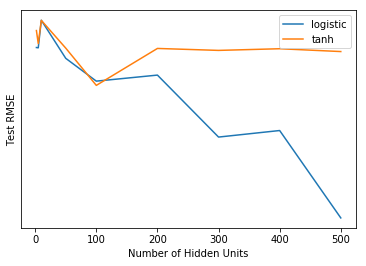

In [35]:
# MLP Regressor Model
# one layer

kf = KFold(5, shuffle=True)
hidden_layers = [2,5,10,50,100,200,300,400,500]

def getRMSE(X, y, hidden_layers, activation_function):
    print(activation_function, ': ')
    
    RMSE = []
    RMSE_min = 1e12
    for i in hidden_layers:
        print('Number of hidden layers = ', i)
        model = MLPRegressor(hidden_layer_sizes=i, activation=activation_function, random_state = 42, max_iter=100000)
        model.fit(X, y)
        pred = model.predict(X)
        RMSE_test = np.sqrt(mean_squared_error(y, pred))
        RMSE.append(RMSE_test)
        if RMSE_test < RMSE_min:
            RMSE_min = RMSE_test
    
    print(RMSE)
    print('Minimum MSE = ', RMSE_min)
    
    ax.plot(hidden_layers, RMSE, label=activation_function)
    ax.set_xlabel('Number of Hidden Units')
    ax.set_ylabel('Test RMSE')
    ax.set_yscale('log')
    plt.legend()
    

fig, ax = plt.subplots()

getRMSE(X, y, hidden_layers, 'logistic')
getRMSE(X, y, hidden_layers, 'tanh')

plt.show()

logistic : 
Number of hidden layers =  (10, 10)


C:\Users\MyLittleGiftToMinya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Number of hidden layers =  (20, 10)
Number of hidden layers =  (20, 20)
Number of hidden layers =  (50, 50)
Number of hidden layers =  (100, 100)
Number of hidden layers =  (200, 200)
[28443.981591592787, 28444.09875841569, 28380.38820623823, 28378.480785872398, 28417.989732970007, 28384.012590969585]
Minimum MSE =  28378.480785872398
tanh : 
Number of hidden layers =  (10, 10)
Number of hidden layers =  (20, 10)
Number of hidden layers =  (20, 20)
Number of hidden layers =  (50, 50)
Number of hidden layers =  (100, 100)
Number of hidden layers =  (200, 200)
[28788.103795861836, 28443.812738672033, 28380.381475064314, 28575.403698808364, 28457.392518130186, 28367.00906982105]
Minimum MSE =  28367.00906982105


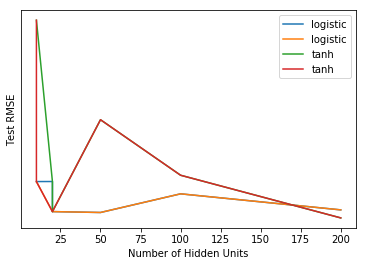

In [37]:
# MLP Regressor Model
# two layers

hidden_layers = [(10,10), (20, 10), (20,20), (50,50), (100,100), (200,200)]

def getMSE(X, y, hidden_layers, activation_function):
    print(activation_function, ': ')
    scheme_id = np.arange(len(hidden_layers))
    RMSE = []
    RMSE_min = 10000000
    
    for i in hidden_layers:
        print('Number of hidden layers = ', i)
        model = MLPRegressor(hidden_layer_sizes=i, activation=activation_function, random_state = 42, max_iter=100000)
        scores = cross_validate(model, X, y, scoring=['neg_mean_squared_error'], cv=kf, return_train_score=True)
        RMSE_test = np.mean(np.sqrt(np.abs(scores['test_neg_mean_squared_error'])))
        RMSE.append(RMSE_test)
        if RMSE_test < RMSE_min:
            RMSE_min = RMSE_test
    
    print(RMSE)
    print('Minimum MSE = ', RMSE_min)
    ax.plot(scheme_id, RMSE, label=activation_function)
    ax.set_yscale('log')
    ax.set_xlabel('Two-layer MLP Schemes')
    ax.set_ylabel('Test MSE')
    plt.legend()

fig, ax = plt.subplots()

getRMSE(X, y, hidden_layers, 'logistic')
getRMSE(X, y, hidden_layers, 'tanh')

plt.show()

# Q12

The idea behind StandardScaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1. Given the distribution of the data, each value in the dataset will have the sample mean value subtracted, and then divided by the standard deviation of the whole dataset.

Scaling inputs helps to avoid the situation, when one or several features dominate others in magnitude.

In [67]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()
y_1 = np.reshape(y, (X.shape[0],1))
X_scaled, y_scaled = scaler_X.fit_transform(X), scaler_y.fit_transform(y_1)

In [53]:
activation_function = 'tanh'
hidden_layer_size = (200,200,200)
model = MLPRegressor(hidden_layer_sizes=hidden_layer_size, activation=activation_function, random_state = 42, max_iter = 10000)
model.fit(X_scaled, np.reshape(y_scaled, (582)))
pred_scaled = model.predict(X_scaled)

print(pred_scaled.shape)
pred_scaled = np.reshape(pred_scaled, (582,1))

pred = scaler_y.inverse_transform(pred_scaled)


RMSE = np.sqrt(mean_squared_error(y, pred))
print(RMSE)

(582,)
13684.99001333659


Analysis: 
yes

# Q13

In [136]:
# Preprocessing
from time import mktime
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV

kf = KFold(5, shuffle=True)

time_1 = datetime.datetime(2015, 2, 1, 8, 0, 0, 0)
time_2 = datetime.datetime(2015, 2, 1, 20, 0, 0, 0)
# convert to UNIX timestamp
# between timemarker_1 and timemarker_2 is super bowl
timemarker_1 = int(mktime(time_1.timetuple()))  # 2/1/2015 8:00AM
timemarker_2 = int(mktime(time_2.timetuple()))  # 2/1/2015 8:00PM

print(timemarker_1)
print(timemarker_2)

1422806400
1422849600


## First Time Period

In [137]:
#initialize time bins, 1-hour window

window = 3600
start_time_1 = min(start_time_list)
end_time_1 = timemarker_1
tweet_dict_1 = defaultdict(list)

tweet_dict_1, time_bins_1 = getDict(start_time_1, end_time_1, window, tweet_dict_1)
X_1, y_1 = getFeatureMat(tweet_dict_1, time_bins_1)

progress:  0 out of 2823738
progress:  10000 out of 2823738
progress:  20000 out of 2823738
progress:  30000 out of 2823738
progress:  40000 out of 2823738
progress:  50000 out of 2823738
progress:  60000 out of 2823738
progress:  70000 out of 2823738
progress:  80000 out of 2823738
progress:  90000 out of 2823738
progress:  100000 out of 2823738
progress:  110000 out of 2823738
progress:  120000 out of 2823738
progress:  130000 out of 2823738
progress:  140000 out of 2823738
progress:  150000 out of 2823738
progress:  160000 out of 2823738
progress:  170000 out of 2823738
progress:  180000 out of 2823738
progress:  190000 out of 2823738
progress:  200000 out of 2823738
progress:  210000 out of 2823738
progress:  220000 out of 2823738
progress:  230000 out of 2823738
progress:  240000 out of 2823738
progress:  250000 out of 2823738
progress:  260000 out of 2823738
progress:  270000 out of 2823738
progress:  280000 out of 2823738
progress:  290000 out of 2823738
progress:  300000 out of

progress:  2450000 out of 2823738
progress:  2460000 out of 2823738
progress:  2470000 out of 2823738
progress:  2480000 out of 2823738
progress:  2490000 out of 2823738
progress:  2500000 out of 2823738
progress:  2510000 out of 2823738
progress:  2520000 out of 2823738
progress:  2530000 out of 2823738
progress:  2540000 out of 2823738
progress:  2550000 out of 2823738
progress:  2560000 out of 2823738
progress:  2570000 out of 2823738
progress:  2580000 out of 2823738
progress:  2590000 out of 2823738
progress:  2600000 out of 2823738
progress:  2610000 out of 2823738
progress:  2620000 out of 2823738
progress:  2630000 out of 2823738
progress:  2640000 out of 2823738
progress:  2650000 out of 2823738
progress:  2660000 out of 2823738
progress:  2670000 out of 2823738
progress:  2680000 out of 2823738
progress:  2690000 out of 2823738
progress:  2700000 out of 2823738
progress:  2710000 out of 2823738
progress:  2720000 out of 2823738
progress:  2730000 out of 2823738
progress:  274

In [138]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()
y_temp = np.reshape(y_1, (X_1.shape[0],1))
X_scaled_1, y_scaled_1 = scaler_X.fit_transform(X_1), scaler_y.fit_transform(y_temp)

tuned_param = {'hidden_layer_sizes': [(100,100,100), (20,20,20), (200,200), (100,100), (20,20), 20, 50, 100, 200, 500],
               'activation': ["logistic", "relu", "tanh"],
               'alpha' : [0.01, 0.001, 0.0001],
               'max_iter' : [1000, 2000, 3000, 5000, 10000],
               'random_state' : [42]}

gs_1 = GridSearchCV(MLPRegressor(), param_grid=tuned_param, cv=5,scoring='neg_mean_squared_error')
gs_1.fit(X_scaled_1, np.reshape(y_scaled_1, (435)))

# get best parameters
optimal_parameters_1 = gs_1.best_params_
print('Optimal parameters for MLP Regressor: ', optimal_parameters_1)

Optimal parameters for MLP Regressor:  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'max_iter': 1000, 'random_state': 42}


In [139]:
# use best parameters to train and get MSE
model_1 = MLPRegressor(hidden_layer_sizes=100, alpha=0.0001, activation='tanh', max_iter=1000, random_state=42)
model_1.fit(X_scaled_1, np.reshape(y_scaled_1, (435)))
pred_scaled = model_1.predict(X_scaled_1)
pred_scaled = np.reshape(pred_scaled, (435,1))
pred = scaler_y.inverse_transform(pred_scaled)

RMSE_1 = np.sqrt(mean_squared_error(y_1, pred))
print('MSE of scaled data for the first time period with 1-hour windows =', RMSE_1)

MSE of scaled data for the first time period with 1-hour windows = 1700.9232262731555


## Second Time Period

In [140]:
#initialize time bins, 5-min window

window = 5*60
start_time_2 = timemarker_1
end_time_2 = timemarker_2
tweet_dict_2 = defaultdict(list)

tweet_dict_2, time_bins_2 = getDict(start_time_2, end_time_2, window, tweet_dict_2)
X_2, y_2 = getFeatureMat(tweet_dict_2, time_bins_2)

progress:  0 out of 2823738
progress:  10000 out of 2823738
progress:  20000 out of 2823738
progress:  30000 out of 2823738
progress:  40000 out of 2823738
progress:  50000 out of 2823738
progress:  60000 out of 2823738
progress:  70000 out of 2823738
progress:  80000 out of 2823738
progress:  90000 out of 2823738
progress:  100000 out of 2823738
progress:  110000 out of 2823738
progress:  120000 out of 2823738
progress:  130000 out of 2823738
progress:  140000 out of 2823738
progress:  150000 out of 2823738
progress:  160000 out of 2823738
progress:  170000 out of 2823738
progress:  180000 out of 2823738
progress:  190000 out of 2823738
progress:  200000 out of 2823738
progress:  210000 out of 2823738
progress:  220000 out of 2823738
progress:  230000 out of 2823738
progress:  240000 out of 2823738
progress:  250000 out of 2823738
progress:  260000 out of 2823738
progress:  270000 out of 2823738
progress:  280000 out of 2823738
progress:  290000 out of 2823738
progress:  300000 out of

progress:  2450000 out of 2823738
progress:  2460000 out of 2823738
progress:  2470000 out of 2823738
progress:  2480000 out of 2823738
progress:  2490000 out of 2823738
progress:  2500000 out of 2823738
progress:  2510000 out of 2823738
progress:  2520000 out of 2823738
progress:  2530000 out of 2823738
progress:  2540000 out of 2823738
progress:  2550000 out of 2823738
progress:  2560000 out of 2823738
progress:  2570000 out of 2823738
progress:  2580000 out of 2823738
progress:  2590000 out of 2823738
progress:  2600000 out of 2823738
progress:  2610000 out of 2823738
progress:  2620000 out of 2823738
progress:  2630000 out of 2823738
progress:  2640000 out of 2823738
progress:  2650000 out of 2823738
progress:  2660000 out of 2823738
progress:  2670000 out of 2823738
progress:  2680000 out of 2823738
progress:  2690000 out of 2823738
progress:  2700000 out of 2823738
progress:  2710000 out of 2823738
progress:  2720000 out of 2823738
progress:  2730000 out of 2823738
progress:  274

In [141]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()
y_temp = np.reshape(y_2, (X_2.shape[0],1))
X_scaled_2, y_scaled_2 = scaler_X.fit_transform(X_2), scaler_y.fit_transform(y_temp)

tuned_param = {'hidden_layer_sizes': [(100,100,100), (20,20,20), (200,200), (100,100), (20,20), 20, 50, 100, 200, 500],
               'activation': ["logistic", "relu", "tanh"],
               'alpha' : [0.01, 0.001, 0.0001],
               'max_iter' : [1000, 2000, 3000, 5000, 10000],
               'random_state' : [42]}

gs_2 = GridSearchCV(MLPRegressor(), param_grid=tuned_param, cv=5,scoring='neg_mean_squared_error')
gs_2.fit(X_scaled_2, np.reshape(y_scaled_2, (143)))
# get best parameters
optimal_parameters_2 = gs_2.best_params_
print('Optimal parameters for MLP Regressor: ', optimal_parameters_2)

Optimal parameters for MLP Regressor:  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 20), 'max_iter': 1000, 'random_state': 42}


In [142]:
# use best parameters to train and get MSE
model_2 = MLPRegressor(hidden_layer_sizes=(20,20), alpha=0.0001, activation='tanh', max_iter=1000, random_state=42)

model_2.fit(X_scaled_2, np.reshape(y_scaled_2, (143)))
pred_scaled = model_2.predict(X_scaled_2)
pred_scaled = np.reshape(pred_scaled, (143,1))
pred = scaler_y.inverse_transform(pred_scaled)

RMSE_2 = np.sqrt(mean_squared_error(y_2, pred))
print('MSE of scaled data for the second time period with 5-min windows =', RMSE_2)

MSE of scaled data for the second time period with 5-min windows = 4181.166446153538


## Third Time Period

In [222]:
#initialize time bins, 1-hour window

window = 3600
start_time_3 = timemarker_2
end_time_3 = max(end_time_list)
tweet_dict_3 = defaultdict(list)

tweet_dict_3, time_bins_3 = getDict(start_time_3, end_time_3, window, tweet_dict_3)
X_3, y_3 = getFeatureMat(tweet_dict_3, time_bins_3)

progress:  0 out of 2823738
progress:  10000 out of 2823738
progress:  20000 out of 2823738
progress:  30000 out of 2823738
progress:  40000 out of 2823738
progress:  50000 out of 2823738
progress:  60000 out of 2823738
progress:  70000 out of 2823738
progress:  80000 out of 2823738
progress:  90000 out of 2823738
progress:  100000 out of 2823738
progress:  110000 out of 2823738
progress:  120000 out of 2823738
progress:  130000 out of 2823738
progress:  140000 out of 2823738
progress:  150000 out of 2823738
progress:  160000 out of 2823738
progress:  170000 out of 2823738
progress:  180000 out of 2823738
progress:  190000 out of 2823738
progress:  200000 out of 2823738
progress:  210000 out of 2823738
progress:  220000 out of 2823738
progress:  230000 out of 2823738
progress:  240000 out of 2823738
progress:  250000 out of 2823738
progress:  260000 out of 2823738
progress:  270000 out of 2823738
progress:  280000 out of 2823738
progress:  290000 out of 2823738
progress:  300000 out of

progress:  2450000 out of 2823738
progress:  2460000 out of 2823738
progress:  2470000 out of 2823738
progress:  2480000 out of 2823738
progress:  2490000 out of 2823738
progress:  2500000 out of 2823738
progress:  2510000 out of 2823738
progress:  2520000 out of 2823738
progress:  2530000 out of 2823738
progress:  2540000 out of 2823738
progress:  2550000 out of 2823738
progress:  2560000 out of 2823738
progress:  2570000 out of 2823738
progress:  2580000 out of 2823738
progress:  2590000 out of 2823738
progress:  2600000 out of 2823738
progress:  2610000 out of 2823738
progress:  2620000 out of 2823738
progress:  2630000 out of 2823738
progress:  2640000 out of 2823738
progress:  2650000 out of 2823738
progress:  2660000 out of 2823738
progress:  2670000 out of 2823738
progress:  2680000 out of 2823738
progress:  2690000 out of 2823738
progress:  2700000 out of 2823738
progress:  2710000 out of 2823738
progress:  2720000 out of 2823738
progress:  2730000 out of 2823738
progress:  274

In [224]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()
y_temp = np.reshape(y_3, (X_3.shape[0],1))
X_scaled_3, y_scaled_3 = scaler_X.fit_transform(X_3), scaler_y.fit_transform(y_temp)

tuned_param = {'hidden_layer_sizes': [(100,100,100), (20,20,20), (200,200), (100,100), (20,20), 20, 50, 100, 200, 500],
               'activation': ["logistic", "relu", "tanh"],
               'alpha' : [0.01, 0.001, 0.0001],
               'max_iter' : [1000, 2000, 3000, 5000, 10000],
               'random_state' : [42]}

gs_3 = GridSearchCV(MLPRegressor(), param_grid=tuned_param, cv=5,scoring='neg_mean_squared_error')
gs_3.fit(X_scaled_3, np.reshape(y_scaled_3, (101)))
# get best parameters
optimal_parameters_3 = gs_3.best_params_
print('Optimal parameters for MLP Regressor: ', optimal_parameters_3)

Optimal parameters for MLP Regressor:  {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000, 'random_state': 42}


In [225]:
# use best parameters to train and get MSE
model_3 = MLPRegressor(hidden_layer_sizes=(100,100), alpha=0.01, activation='tanh', max_iter=1000, random_state=42)

model_3.fit(X_scaled_3, np.reshape(y_scaled_3, (101)))
pred_scaled = model_3.predict(X_scaled_3)
pred_scaled = np.reshape(pred_scaled, (101,1))
pred = scaler_y.inverse_transform(pred_scaled)

RMSE_3 = np.sqrt(mean_squared_error(y_3, pred))
print('MSE of scaled data for the third time period with 1-hour windows =', RMSE_3)

MSE of scaled data for the third time period with 1-hour windows = 643.1552108153984


# Q14

In [145]:
def getDict_select_rawmat(raw_mat, start_time, end_time, window, tweet_dict):
    #initialize time bins
    time_bins = np.arange(start_time, end_time + window, window)

    for time_bin in time_bins:
        tweet_dict[time_bin] = []
    
    N = raw_mat.shape[0]
    
    for index in range(N):
        if index%10000 == 0:
            print('progress: ', index, 'out of', N)
        tweet = raw_mat[index]
        for i, time_bin in enumerate(time_bins):
            if i < time_bins.shape[0]-1 and time_bins[i] <= tweet[2] < time_bins[i+1]:  
                tweet_dict[time_bin].append(tweet)
                
    return tweet_dict, time_bins


In [275]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

def getX(raw_mat):
    X_test = np.zeros((1,5))
    num_tweets = raw_mat.shape[0]
    num_retweets = 0
    sum_num_followers = 0
    max_num_followers = 0
    time_of_day = raw_mat[-1,-1]
    
    for i in range(raw_mat.shape[0]):
        num_retweets += raw_mat[i,0]
        sum_num_followers += raw_mat[i,1]
        
        if raw_mat[i,1] > max_num_followers:
            max_num_followers = raw_mat[i,1]
            
    X_test = np.array([num_tweets, num_retweets, sum_num_followers, max_num_followers, time_of_day])
    
    return X_test

def getTestFeatureMat(filenames):
    start_time = 0
    start_time_list = []
    end_time = 0
    end_time_list = []
    matrices = []
    
    for filename in filenames:
        file_name = filename + '.txt'
        f = open(file_name, 'r', encoding = 'utf-8')
        print('Loading: ' , file_name)
        
        # initialization
        mat_temp = np.zeros((len(f.readlines()),3))   # 3 parameters: num_retweets, num_followers, time_of_day
        print(mat_temp.shape)
        
        # read line by line for the current file and fill in raw_mat
        file_name = filename + '.txt'
        f = open(file_name, 'r', encoding = 'utf-8')
        for lineNum, line in enumerate(f) : 
            tweet = json.loads(line)

            # get start time and end time of tweets of the current txt file
            if lineNum == 0 :
                start_time_list.append(tweet['citation_date']) 
            
            end_time = tweet['citation_date']
            
            # fill in raw feature matrix 
            # raw_mat_i: for i-th sample
            # 3 columns: 
            # raw_mat[:,0]: num_retweets
            # raw_mat[:,1]: num_followers
            # raw_mat[:,2]: time_of_day
            mat_temp[lineNum][0] = tweet['metrics']['citations']['total'] # num_retweets
            mat_temp[lineNum][1] = tweet['author']['followers'] # num_followers
            mat_temp[lineNum][2] = tweet['citation_date'] # time_of_day
            
        end_time_list.append(end_time)
        matrices.append(mat_temp)
    
    raw_mat_1 = matrices[0] # raw feature matrix for sample 0
    raw_mat_2 = matrices[1] # raw feature matrix for sample 1
    raw_mat_3 = matrices[2] # raw feature matrix for sample 2
    
    # sample 0
    X_test_1 = getX(raw_mat_1)
    
    
    # sample 1
    X_test_2 = getX(raw_mat_2)
    
    # sample 2
    X_test_3 = getX(raw_mat_3)
    
    return X_test_1, X_test_2, X_test_3


In [227]:
def testModel(model, X_test_1, X_test_2, X_test_3):
    y = np.zeros((3))
    y[0] = model.predict(X_test_1)
    y[1] = model.predict(X_test_2)
    y[2] = model.predict(X_test_3)
    
    return y

In [228]:
def getDates(filenames):
    end_time_list = []
    start_time_list = []
    for filename in filenames:
        start_time = 0
        end_time = 0
        matrices = []
        
        file_name = filename + '.txt'
        f = open(file_name, 'r', encoding = 'utf-8')
        print('Loading: ' , file_name)
            
        # read line by line for the current file and fill in raw_mat
        f = open(file_name, 'r', encoding = 'utf-8')
        for lineNum, line in enumerate(f) : 
            tweet = json.loads(line)
        
            # get start time and end time of tweets of the current txt file
            if lineNum == 0 :
                start_time_list.append(tweet['firstpost_date']) 
                
            end_time = tweet['citation_date']
        end_time_list.append(end_time)
        
    return start_time_list, end_time_list


In [229]:
cycle_len = 6

#### Period 1:  Fit a model to train with 6-hour windows, and make prediction on the next hour

In [276]:
window_size = 3600*(cycle_len)
tweet_dict_4_train = defaultdict(list)

tweet_dict_4_train, time_bins_4_train = getDict(start_time_1, end_time_1, window_size, tweet_dict_4_train)
X_4_train, _ = getFeatureMat(tweet_dict_4_train, time_bins_4_train)
print('X shape = ', X_4_train.shape)

y_4_train = y_1[(cycle_len-2)::(cycle_len)]
print('y shape = ', y_4_train.shape)


progress:  0 out of 2823738
progress:  10000 out of 2823738
progress:  20000 out of 2823738
progress:  30000 out of 2823738
progress:  40000 out of 2823738
progress:  50000 out of 2823738
progress:  60000 out of 2823738
progress:  70000 out of 2823738
progress:  80000 out of 2823738
progress:  90000 out of 2823738
progress:  100000 out of 2823738
progress:  110000 out of 2823738
progress:  120000 out of 2823738
progress:  130000 out of 2823738
progress:  140000 out of 2823738
progress:  150000 out of 2823738
progress:  160000 out of 2823738
progress:  170000 out of 2823738
progress:  180000 out of 2823738
progress:  190000 out of 2823738
progress:  200000 out of 2823738
progress:  210000 out of 2823738
progress:  220000 out of 2823738
progress:  230000 out of 2823738
progress:  240000 out of 2823738
progress:  250000 out of 2823738
progress:  260000 out of 2823738
progress:  270000 out of 2823738
progress:  280000 out of 2823738
progress:  290000 out of 2823738
progress:  300000 out of

progress:  2450000 out of 2823738
progress:  2460000 out of 2823738
progress:  2470000 out of 2823738
progress:  2480000 out of 2823738
progress:  2490000 out of 2823738
progress:  2500000 out of 2823738
progress:  2510000 out of 2823738
progress:  2520000 out of 2823738
progress:  2530000 out of 2823738
progress:  2540000 out of 2823738
progress:  2550000 out of 2823738
progress:  2560000 out of 2823738
progress:  2570000 out of 2823738
progress:  2580000 out of 2823738
progress:  2590000 out of 2823738
progress:  2600000 out of 2823738
progress:  2610000 out of 2823738
progress:  2620000 out of 2823738
progress:  2630000 out of 2823738
progress:  2640000 out of 2823738
progress:  2650000 out of 2823738
progress:  2660000 out of 2823738
progress:  2670000 out of 2823738
progress:  2680000 out of 2823738
progress:  2690000 out of 2823738
progress:  2700000 out of 2823738
progress:  2710000 out of 2823738
progress:  2720000 out of 2823738
progress:  2730000 out of 2823738
progress:  274

In [277]:
import datetime
import pytz

pst_tz = pytz.timezone('America/Los_Angeles')
filenames = ['sample0_period1', 'sample1_period1', 'sample2_period1']

start_time_list, end_time_list = getDates(filenames)

print()
print('Sample 0 start and end date for period 1:')
print('UNIX dataset start date:', start_time_list[0])
print('PST dataset start date:', datetime.datetime.fromtimestamp(start_time_list[0], pst_tz))
print('UNIX dataset end date:', end_time_list[0])
print('PST dataset end date:', datetime.datetime.fromtimestamp(end_time_list[0], pst_tz))
print()
print('Sample 1 start and end date for period 1:')
print('UNIX dataset start date:', start_time_list[1])
print('PST dataset start date:', datetime.datetime.fromtimestamp(start_time_list[1], pst_tz))
print('UNIX dataset end date:', end_time_list[1])
print('PST dataset end date:', datetime.datetime.fromtimestamp(end_time_list[1], pst_tz))
print()
print('Sample 2 start and end date for period 1:')
print('UNIX dataset start date:', start_time_list[2])
print('PST dataset start date:', datetime.datetime.fromtimestamp(start_time_list[2], pst_tz))
print('UNIX dataset end date:', end_time_list[2])
print('PST dataset end date:', datetime.datetime.fromtimestamp(end_time_list[2], pst_tz))

Loading:  sample0_period1.txt
Loading:  sample1_period1.txt
Loading:  sample2_period1.txt

Sample 0 start and end date for period 1:
UNIX dataset start date: 1422709237
PST dataset start date: 2015-01-31 05:00:37-08:00
UNIX dataset end date: 1422729038
PST dataset end date: 2015-01-31 10:30:38-08:00

Sample 1 start and end date for period 1:
UNIX dataset start date: 1422781210
PST dataset start date: 2015-02-01 01:00:10-08:00
UNIX dataset end date: 1422798026
PST dataset end date: 2015-02-01 05:40:26-08:00

Sample 2 start and end date for period 1:
UNIX dataset start date: 1422320759
PST dataset start date: 2015-01-26 17:05:59-08:00
UNIX dataset end date: 1422334141
PST dataset end date: 2015-01-26 20:49:01-08:00


In [278]:
# Train model
clf = RandomForestRegressor(random_state=42)
model_4 = clf.fit(X_4_train, y_4_train)

# Get feature matrix from test data for period 1
filenames = ['sample0_period1', 'sample1_period1', 'sample2_period1']
X_test_1, X_test_2, X_test_3 = getTestFeatureMat(filenames)

# test model for period 1
pred_1 = testModel(model_4, X_test_1.reshape(1, -1), X_test_2.reshape(1, -1), X_test_3.reshape(1, -1))

print(pred_1)

Loading:  sample0_period1.txt
(568, 3)
Loading:  sample1_period1.txt
(2280, 3)
Loading:  sample2_period1.txt
(953, 3)
[182.1 486.2 199.4]


#### Period 2:  Fit a model to train with 30-min windows, and make prediction on the next 5 min

In [279]:
import datetime
import pytz

pst_tz = pytz.timezone('America/Los_Angeles')
filenames = ['sample0_period2', 'sample1_period2', 'sample2_period2']

start_time_list, end_time_list = getDates(filenames)

print()
print('Sample 0 start and end date for period 2:')
print('UNIX dataset start date:', start_time_list[0])
print('PST dataset start date:', datetime.datetime.fromtimestamp(start_time_list[0], pst_tz))
print('UNIX dataset end date:', end_time_list[0])
print('PST dataset end date:', datetime.datetime.fromtimestamp(end_time_list[0], pst_tz))
print()
print('Sample 1 start and end date for period 2:')
print('UNIX dataset start date:', start_time_list[1])
print('PST dataset start date:', datetime.datetime.fromtimestamp(start_time_list[1], pst_tz))
print('UNIX dataset end date:', end_time_list[1])
print('PST dataset end date:', datetime.datetime.fromtimestamp(end_time_list[1], pst_tz))
print()
print('Sample 2 start and end date for period 2:')
print('UNIX dataset start date:', start_time_list[2])
print('PST dataset start date:', datetime.datetime.fromtimestamp(start_time_list[2], pst_tz))
print('UNIX dataset end date:', end_time_list[2])
print('PST dataset end date:', datetime.datetime.fromtimestamp(end_time_list[2], pst_tz))

Loading:  sample0_period2.txt
Loading:  sample1_period2.txt
Loading:  sample2_period2.txt

Sample 0 start and end date for period 2:
UNIX dataset start date: 1422846005
PST dataset start date: 2015-02-01 19:00:05-08:00
UNIX dataset end date: 1422847788
PST dataset end date: 2015-02-01 19:29:48-08:00

Sample 1 start and end date for period 2:
UNIX dataset start date: 1422822618
PST dataset start date: 2015-02-01 12:30:18-08:00
UNIX dataset end date: 1422824391
PST dataset end date: 2015-02-01 12:59:51-08:00

Sample 2 start and end date for period 2:
UNIX dataset start date: 1422808212
PST dataset start date: 2015-02-01 08:30:12-08:00
UNIX dataset end date: 1422809955
PST dataset end date: 2015-02-01 08:59:15-08:00


In [280]:
tweet_dict_5_train = defaultdict(list)
window_size = (cycle_len)*(5*60)

tweet_dict_5_train, time_bins_5_train = getDict(start_time_2, end_time_2, window_size, tweet_dict_5_train)
X_5_train, _ = getFeatureMat(tweet_dict_5_train, time_bins_5_train)
print(X_5_train.shape)

y_5_train = y_2[(cycle_len-2)::(cycle_len)]
y_5_train = y_5_train[:-1]
print(y_5_train.shape)

progress:  0 out of 2823738
progress:  10000 out of 2823738
progress:  20000 out of 2823738
progress:  30000 out of 2823738
progress:  40000 out of 2823738
progress:  50000 out of 2823738
progress:  60000 out of 2823738
progress:  70000 out of 2823738
progress:  80000 out of 2823738
progress:  90000 out of 2823738
progress:  100000 out of 2823738
progress:  110000 out of 2823738
progress:  120000 out of 2823738
progress:  130000 out of 2823738
progress:  140000 out of 2823738
progress:  150000 out of 2823738
progress:  160000 out of 2823738
progress:  170000 out of 2823738
progress:  180000 out of 2823738
progress:  190000 out of 2823738
progress:  200000 out of 2823738
progress:  210000 out of 2823738
progress:  220000 out of 2823738
progress:  230000 out of 2823738
progress:  240000 out of 2823738
progress:  250000 out of 2823738
progress:  260000 out of 2823738
progress:  270000 out of 2823738
progress:  280000 out of 2823738
progress:  290000 out of 2823738
progress:  300000 out of

progress:  2450000 out of 2823738
progress:  2460000 out of 2823738
progress:  2470000 out of 2823738
progress:  2480000 out of 2823738
progress:  2490000 out of 2823738
progress:  2500000 out of 2823738
progress:  2510000 out of 2823738
progress:  2520000 out of 2823738
progress:  2530000 out of 2823738
progress:  2540000 out of 2823738
progress:  2550000 out of 2823738
progress:  2560000 out of 2823738
progress:  2570000 out of 2823738
progress:  2580000 out of 2823738
progress:  2590000 out of 2823738
progress:  2600000 out of 2823738
progress:  2610000 out of 2823738
progress:  2620000 out of 2823738
progress:  2630000 out of 2823738
progress:  2640000 out of 2823738
progress:  2650000 out of 2823738
progress:  2660000 out of 2823738
progress:  2670000 out of 2823738
progress:  2680000 out of 2823738
progress:  2690000 out of 2823738
progress:  2700000 out of 2823738
progress:  2710000 out of 2823738
progress:  2720000 out of 2823738
progress:  2730000 out of 2823738
progress:  274

In [281]:
# Train model
clf = RandomForestRegressor(random_state=42)
model_5 = clf.fit(X_5_train, y_5_train)

# Get feature matrix from test data for period 2
filenames = ['sample0_period2', 'sample1_period2', 'sample2_period2']
X_test_1, X_test_2, X_test_3 = getTestFeatureMat(filenames)

# test model for period 1
pred_2 = testModel(model_5, X_test_1.reshape(1, -1), X_test_2.reshape(1, -1), X_test_3.reshape(1, -1))

print(pred_2)

Loading:  sample0_period2.txt
(13377, 3)
Loading:  sample1_period2.txt
(5549, 3)
Loading:  sample2_period2.txt
(152, 3)
[3846.6 3866.5  967.3]


#### Period 3:  Fit a model to train with 6-hour windows, and make prediction on the next hour

In [282]:
import datetime
import pytz

pst_tz = pytz.timezone('America/Los_Angeles')
filenames = ['sample0_period3', 'sample1_period3', 'sample2_period3']

start_time_list, end_time_list = getDates(filenames)

print()
print('Sample 0 start and end date for period 3:')
print('UNIX dataset start date:', start_time_list[0])
print('PST dataset start date:', datetime.datetime.fromtimestamp(start_time_list[0], pst_tz))
print('UNIX dataset end date:', end_time_list[0])
print('PST dataset end date:', datetime.datetime.fromtimestamp(end_time_list[0], pst_tz))
print()
print('Sample 1 start and end date for period 3:')
print('UNIX dataset start date:', start_time_list[1])
print('PST dataset start date:', datetime.datetime.fromtimestamp(start_time_list[1], pst_tz))
print('UNIX dataset end date:', end_time_list[1])
print('PST dataset end date:', datetime.datetime.fromtimestamp(end_time_list[1], pst_tz))
print()
print('Sample 2 start and end date for period 3:')
print('UNIX dataset start date:', start_time_list[2])
print('PST dataset start date:', datetime.datetime.fromtimestamp(start_time_list[2], pst_tz))
print()
print('UNIX dataset end date:', end_time_list[2])
print('PST dataset end date:', datetime.datetime.fromtimestamp(end_time_list[2], pst_tz))

Loading:  sample0_period3.txt
Loading:  sample1_period3.txt
Loading:  sample2_period3.txt

Sample 0 start and end date for period 3:
UNIX dataset start date: 1423036816
PST dataset start date: 2015-02-04 00:00:16-08:00
UNIX dataset end date: 1423057567
PST dataset end date: 2015-02-04 05:46:07-08:00

Sample 1 start and end date for period 3:
UNIX dataset start date: 1423195440
PST dataset start date: 2015-02-05 20:04:00-08:00
UNIX dataset end date: 1423216204
PST dataset end date: 2015-02-06 01:50:04-08:00

Sample 2 start and end date for period 3:
UNIX dataset start date: 1423184404
PST dataset start date: 2015-02-05 17:00:04-08:00

UNIX dataset end date: 1423204512
PST dataset end date: 2015-02-05 22:35:12-08:00


In [283]:
tweet_dict_6_train = defaultdict(list)
window_size = (cycle_len)*3600

tweet_dict_6_train, time_bins_6_train = getDict(start_time_3, end_time_3, window_size, tweet_dict_6_train)
X_6_train, _ = getFeatureMat(tweet_dict_6_train, time_bins_6_train)
print(X_6_train.shape)

y_6_train = y_3[(cycle_len-2)::(cycle_len)]
y_6_train = y_6_train[:-1]
print(y_6_train.shape)

progress:  0 out of 2823738
progress:  10000 out of 2823738
progress:  20000 out of 2823738
progress:  30000 out of 2823738
progress:  40000 out of 2823738
progress:  50000 out of 2823738
progress:  60000 out of 2823738
progress:  70000 out of 2823738
progress:  80000 out of 2823738
progress:  90000 out of 2823738
progress:  100000 out of 2823738
progress:  110000 out of 2823738
progress:  120000 out of 2823738
progress:  130000 out of 2823738
progress:  140000 out of 2823738
progress:  150000 out of 2823738
progress:  160000 out of 2823738
progress:  170000 out of 2823738
progress:  180000 out of 2823738
progress:  190000 out of 2823738
progress:  200000 out of 2823738
progress:  210000 out of 2823738
progress:  220000 out of 2823738
progress:  230000 out of 2823738
progress:  240000 out of 2823738
progress:  250000 out of 2823738
progress:  260000 out of 2823738
progress:  270000 out of 2823738
progress:  280000 out of 2823738
progress:  290000 out of 2823738
progress:  300000 out of

progress:  2450000 out of 2823738
progress:  2460000 out of 2823738
progress:  2470000 out of 2823738
progress:  2480000 out of 2823738
progress:  2490000 out of 2823738
progress:  2500000 out of 2823738
progress:  2510000 out of 2823738
progress:  2520000 out of 2823738
progress:  2530000 out of 2823738
progress:  2540000 out of 2823738
progress:  2550000 out of 2823738
progress:  2560000 out of 2823738
progress:  2570000 out of 2823738
progress:  2580000 out of 2823738
progress:  2590000 out of 2823738
progress:  2600000 out of 2823738
progress:  2610000 out of 2823738
progress:  2620000 out of 2823738
progress:  2630000 out of 2823738
progress:  2640000 out of 2823738
progress:  2650000 out of 2823738
progress:  2660000 out of 2823738
progress:  2670000 out of 2823738
progress:  2680000 out of 2823738
progress:  2690000 out of 2823738
progress:  2700000 out of 2823738
progress:  2710000 out of 2823738
progress:  2720000 out of 2823738
progress:  2730000 out of 2823738
progress:  274

In [286]:
# Train model
clf = RandomForestRegressor(random_state=42)
model_6 = clf.fit(X_6_train, y_6_train)

# Get feature matrix from test data for period 2
filenames = ['sample0_period3', 'sample1_period3', 'sample2_period3']
X_test_1, X_test_2, X_test_3 = getTestFeatureMat(filenames)

# test model for period 1
pred_3 = testModel(model_6, X_test_1.reshape(1, -1), X_test_2.reshape(1, -1), X_test_3.reshape(1, -1))

print(pred_3)

Loading:  sample0_period3.txt
(410, 3)
Loading:  sample1_period3.txt
(305, 3)
Loading:  sample2_period3.txt
(399, 3)
[3387.7 3387.7 3387.7]
